# Problem Formulation

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import copy

In [2]:
from ema_workbench import (Model, CategoricalParameter,
                           ScalarOutcome, IntegerParameter, RealParameter)

from ema_workbench import (Model, MultiprocessingEvaluator, Policy, Scenario, SequentialEvaluator)

from ema_workbench.em_framework.evaluators import perform_experiments, optimize
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging, utilities

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [3]:
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation

C:\Users\newbi\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [4]:
dike_model, planning_steps = get_model_for_problem_formulation(5)

In [5]:
for policies in dike_model.levers:
    print(repr(policies))

IntegerParameter('0_RfR 0', 0, 1)
IntegerParameter('0_RfR 1', 0, 1)
IntegerParameter('0_RfR 2', 0, 1)
IntegerParameter('1_RfR 0', 0, 1)
IntegerParameter('1_RfR 1', 0, 1)
IntegerParameter('1_RfR 2', 0, 1)
IntegerParameter('2_RfR 0', 0, 1)
IntegerParameter('2_RfR 1', 0, 1)
IntegerParameter('2_RfR 2', 0, 1)
IntegerParameter('3_RfR 0', 0, 1)
IntegerParameter('3_RfR 1', 0, 1)
IntegerParameter('3_RfR 2', 0, 1)
IntegerParameter('4_RfR 0', 0, 1)
IntegerParameter('4_RfR 1', 0, 1)
IntegerParameter('4_RfR 2', 0, 1)
IntegerParameter('EWS_DaysToThreat', 0, 4)
IntegerParameter('A.1_DikeIncrease 0', 0, 10)
IntegerParameter('A.1_DikeIncrease 1', 0, 10)
IntegerParameter('A.1_DikeIncrease 2', 0, 10)
IntegerParameter('A.2_DikeIncrease 0', 0, 10)
IntegerParameter('A.2_DikeIncrease 1', 0, 10)
IntegerParameter('A.2_DikeIncrease 2', 0, 10)
IntegerParameter('A.3_DikeIncrease 0', 0, 10)
IntegerParameter('A.3_DikeIncrease 1', 0, 10)
IntegerParameter('A.3_DikeIncrease 2', 0, 10)
IntegerParameter('A.4_DikeIncreas

In [39]:
# policies = [Policy("base case", **{k.name:0 for k in dike_model.levers}),
#             Policy("only RfR", **{k.name:1 for k in dike_model.levers if ("RfR" in k.name)}),
#             Policy("only dikes", **{k.name:10 for k in dike_model.levers if ("DikeIncrease" in k.name)})]

# # x if y else z
# # k.name:1 for k in dike_model.levers if "RfR" in k.name

#  policies = [Policy("RfR only", **{k.name:1 for k in dike_model.levers if "RfR" in k.name})]

policies = [Policy("base case", **{k.name:0 for k in dike_model.levers}),
            Policy("RfR only", **{'0_RfR 0': 1, '0_RfR 1': 1, '0_RfR 2': 1, '1_RfR 0': 1, 
                                  '1_RfR 1': 1, '1_RfR 2': 1, '2_RfR 0': 1, '2_RfR 1': 1, 
                                  '2_RfR 2': 1, '3_RfR 0': 1, '3_RfR 1': 1, '3_RfR 2': 1, 
                                  '4_RfR 0': 1, '4_RfR 1': 1, '4_RfR 2': 1,
                                  'EWS_DaysToThreat': 0, 'A.1_DikeIncrease 0': 0, 
                                  'A.1_DikeIncrease 1': 0, 'A.1_DikeIncrease 2': 0, 
                                  'A.2_DikeIncrease 0': 0, 'A.2_DikeIncrease 1': 0, 
                                  'A.2_DikeIncrease 2': 0, 'A.3_DikeIncrease 0': 0, 
                                  'A.3_DikeIncrease 1': 0, 'A.3_DikeIncrease 2': 0, 
                                  'A.4_DikeIncrease 0': 0, 'A.4_DikeIncrease 1': 0, 
                                  'A.4_DikeIncrease 2': 0, 'A.5_DikeIncrease 0': 0, 
                                  'A.5_DikeIncrease 1': 0, 'A.5_DikeIncrease 2': 0}),
            Policy("Dikes only", **{'0_RfR 0': 0, '0_RfR 1': 0, '0_RfR 2': 0, '1_RfR 0': 0, 
                                    '1_RfR 1': 0, '1_RfR 2': 0, '2_RfR 0': 0, '2_RfR 1': 0, 
                                    '2_RfR 2': 0, '3_RfR 0': 0, '3_RfR 1': 0, '3_RfR 2': 0, 
                                    '4_RfR 0': 0, '4_RfR 1': 0, '4_RfR 2': 0, 
                                    'EWS_DaysToThreat': 0, 'A.1_DikeIncrease 0': 10, 
                                    'A.1_DikeIncrease 1': 10, 'A.1_DikeIncrease 2': 10, 
                                    'A.2_DikeIncrease 0': 10, 'A.2_DikeIncrease 1': 10, 
                                    'A.2_DikeIncrease 2': 10, 'A.3_DikeIncrease 0': 10, 
                                    'A.3_DikeIncrease 1': 10, 'A.3_DikeIncrease 2': 10, 
                                    'A.4_DikeIncrease 0': 10, 'A.4_DikeIncrease 1': 10, 
                                    'A.4_DikeIncrease 2': 10, 'A.5_DikeIncrease 0': 10, 
                                    'A.5_DikeIncrease 1': 10, 'A.5_DikeIncrease 2': 10})]

In [42]:
policies[2]

Policy({'0_RfR 0': 0, '0_RfR 1': 0, '0_RfR 2': 0, '1_RfR 0': 0, '1_RfR 1': 0, '1_RfR 2': 0, '2_RfR 0': 0, '2_RfR 1': 0, '2_RfR 2': 0, '3_RfR 0': 0, '3_RfR 1': 0, '3_RfR 2': 0, '4_RfR 0': 0, '4_RfR 1': 0, '4_RfR 2': 0, 'EWS_DaysToThreat': 0, 'A.1_DikeIncrease 0': 10, 'A.1_DikeIncrease 1': 10, 'A.1_DikeIncrease 2': 10, 'A.2_DikeIncrease 0': 10, 'A.2_DikeIncrease 1': 10, 'A.2_DikeIncrease 2': 10, 'A.3_DikeIncrease 0': 10, 'A.3_DikeIncrease 1': 10, 'A.3_DikeIncrease 2': 10, 'A.4_DikeIncrease 0': 10, 'A.4_DikeIncrease 1': 10, 'A.4_DikeIncrease 2': 10, 'A.5_DikeIncrease 0': 10, 'A.5_DikeIncrease 1': 10, 'A.5_DikeIncrease 2': 10})

In [43]:
start = time.time()
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios=10, policies=policies)
    
end = time.time()

print('Total run time:{} min'.format((end - start)/60))

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 10 scenarios * 3 policies * 1 model(s) = 30 experiments
[MainProcess/INFO] 3 cases completed
[MainProcess/INFO] 6 cases completed
[MainProcess/INFO] 9 cases completed
[MainProcess/INFO] 12 cases completed
[MainProcess/INFO] 15 cases completed
[MainProcess/INFO] 18 cases completed
[MainProcess/INFO] 21 cases completed
Traceback (most recent call last):
  File "C:\Users\newbi\Anaconda3\lib\site-packages\ema_workbench\em_framework\ema_multiprocessing.py", line 256, in run
    self.callback(*result.get())
  File "C:\Users\newbi\Anaconda3\lib\site-packages\ema_workbench\em_framework\callbacks.py", line 265, in __call__
    self._store_outcomes(experiment.experiment_id, outcomes)
  File "C:\Users\newbi\Anaconda3\lib\site-packages\ema_workbench\em_framework\callbacks.py", line 230, in _store_outcomes
    self.results[outcome][case_id, ] = outcome_res
OverflowError: Python int too large to convert to C long
Traceback (most recent ca

Total run time:0.7891826430956522 min


In [44]:
results[0].iloc[:, 10:]

,A.4_Bmax,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,discount rate 2,0_RfR 0,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model
0,199.381584,1,0.257881,104.692492,1,0.344980,1.5,3.5,4.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,base case,dikesnet
1,348.460926,1,0.892366,158.847074,10,0.839227,2.5,4.5,2.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,base case,dikesnet
2,285.678641,1.5,0.721741,234.509256,1,0.663519,4.5,1.5,1.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,base case,dikesnet
3,37.695427,10,0.987206,153.386669,1,0.790233,2.5,3.5,4.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,base case,dikesnet
4,129.315773,10,0.560137,285.145005,10,0.217157,1.5,1.5,4.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,base case,dikesnet
5,308.119024,1.5,0.389214,206.673496,1.5,0.535691,4.5,2.5,3.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,base case,dikesnet
6,184.974517,1.5,0.154630,310.181545,10,0.418824,1.5,4.5,3.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,base case,dikesnet
7,88.889682,1,0.049279,32.879356,1.5,0.929385,4.5,1.5,2.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,base case,dikesnet
8,241.739429,10,0.641745,87.027966,1.5,0.108229,3.5,2.5,1.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,base case,dikesnet
9,110.258753,10,0.431354,340.507183,1,0.073414,3.5,4.5,1.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,base case,dikesnet


In [5]:
results = utilities.load_results('Outcomes/1000ScenariosBaseCase.csv')

[MainProcess/INFO] results loaded succesfully from C:\Users\newbi\project-local\Model-based-decision-making\epa1361_open\final assignment\Outcomes\1000ScenariosBaseCase.csv


In [ ]:
# # Write results to file again
# import pickle

# with open('Outcomes/200Scenarios50Policies.pkl', 'wb') as f:
#     pickle.dump(results, f)

In [ ]:
# # Read in results again
# import pickle

# with open('Outcomes/200Scenarios50Policies.pkl', 'rb') as f:
#     results = pickle.load(f)

In [ ]:
# # Do the same thing but Jan's way (slower)
# from ema_workbench.util import utilities

# utilities.save_results(results, 'Outcomes/200Scenarios50Policies.csv')

In [ ]:
results = utilities.load_results('Outcomes/200Scenarios50Policies.csv')

In [6]:
experiments, outcomes = results
outcomes = pd.DataFrame(outcomes)
experiments = pd.DataFrame(experiments)
results = experiments.join(outcomes)
results.head()

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_Dike Investment Costs 2,A.3_Expected Number of Deaths 2,A.4_Expected Annual Damage 2,A.4_Dike Investment Costs 2,A.4_Expected Number of Deaths 2,A.5_Expected Annual Damage 2,A.5_Dike Investment Costs 2,A.5_Expected Number of Deaths 2,RfR Total Costs 2,Expected Evacuation Costs 2
0,64.0,341.707998,10.0,0.008967,329.059434,1.0,0.671443,46.836038,1.0,0.541864,...,0,0.000000,0.0,0,0.0,0.0,0,0.0,0.0,0.0
1,49.0,270.516534,1.0,0.389864,64.116779,1.0,0.458602,211.600292,1.5,0.030226,...,0,1.053592,0.0,0,0.0,0.0,0,0.0,0.0,0.0
2,109.0,217.092157,1.0,0.720433,119.844801,1.5,0.445405,332.843340,10.0,0.123183,...,0,1.091069,0.0,0,0.0,0.0,0,0.0,0.0,0.0
3,106.0,314.195207,1.0,0.000931,149.934556,10.0,0.203409,177.126583,1.5,0.900999,...,0,0.000000,0.0,0,0.0,0.0,0,0.0,0.0,0.0
4,123.0,331.097660,1.5,0.138750,275.055604,1.0,0.296295,172.209395,1.5,0.888339,...,0,0.000000,0.0,0,0.0,0.0,0,0.0,0.0,0.0


In [8]:
# Changes so that the dataframe is fit for mathematical opertions
results = results.drop(columns="model")
results = results.apply(pd.to_numeric)

KeyError: "['model'] not found in axis"

# Data Visualization

## Histograms of the outcomes per location and timestep

In [44]:
def histogram_maker(results, outcome, n = 3):
    locations = ["A.1", "A.2", "A.3", "A.4", "A.5"]
    colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:pink', 'tab:olive']


    print("Plot " + str(outcome) + "(Histogram)")
    for step in range(0, n):
        print("This is timestep " + str(step))
        fig, axes = plt.subplots(1, 5, figsize=(10, 3))

        for i, (ax, place) in enumerate(zip(axes.flatten(), locations)):
            ax.hist(results[str(place) + "_Expected Annual Damage " + str(step)], color=colors[i])
            ax.set_xlim(left = 0)
            ax.set_title(place)

        plt.tight_layout()
        plt.show()

Plot _Expected Annual Damage (Histogram)
This is timestep 0


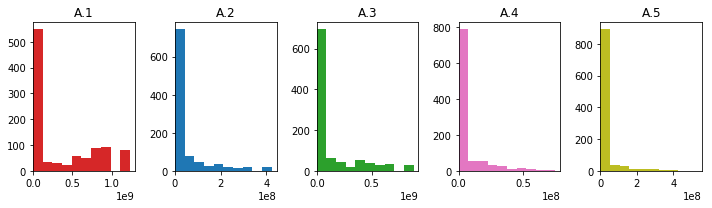

This is timestep 1


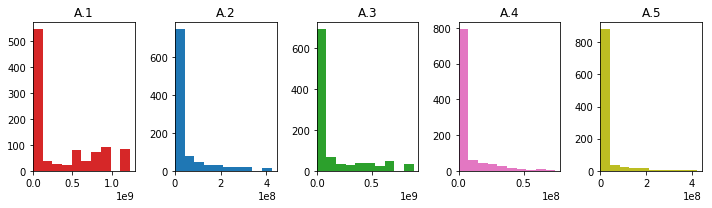

This is timestep 2


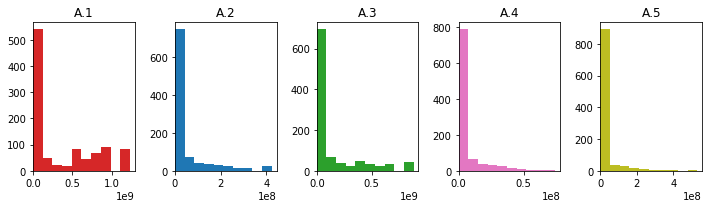

Plot _Expected Number of Deaths (Histogram)
This is timestep 0


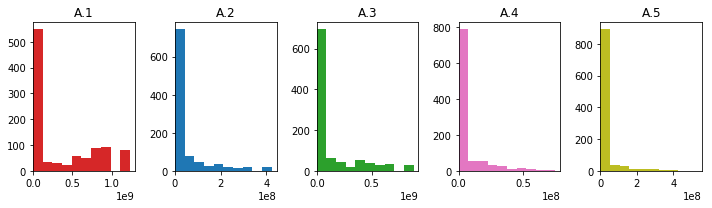

This is timestep 1


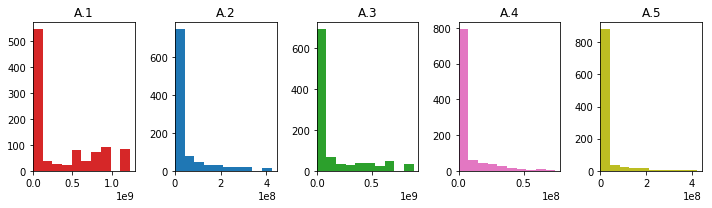

This is timestep 2


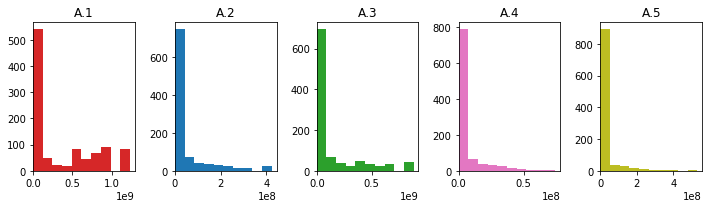

In [59]:
histogram_maker(results, "_Expected Annual Damage ")
histogram_maker(results, "_Expected Number of Deaths ")

Plot Expected Annual Damages (Histogram)
This is timestep 0


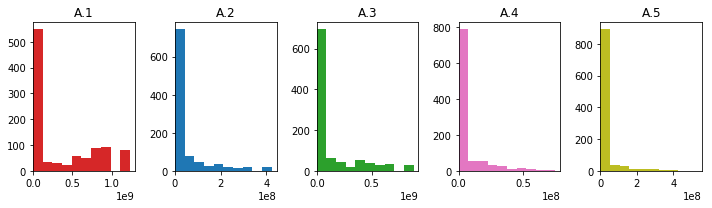

This is timestep 1


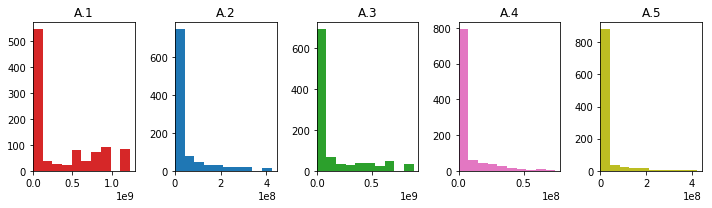

This is timestep 2


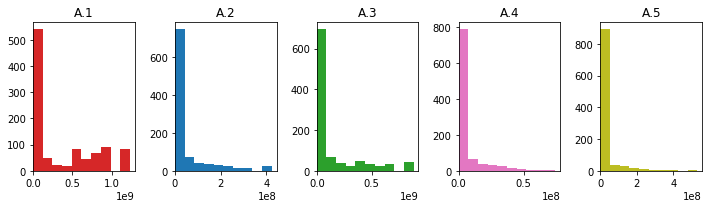

In [9]:
# # Plot Expected Annual Damages (Histogram)
# x = [0,1,2]
# locations = ["A.1", "A.2", "A.3", "A.4", "A.5"]
# colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:pink', 'tab:olive']


# print("Plot Expected Annual Damages (Histogram)")
# for step in x:
#     print("This is timestep " + str(step))
#     fig, axes = plt.subplots(1, 5, figsize=(10, 3))

#     for i, (ax, place) in enumerate(zip(axes.flatten(), locations)):
#         ax.hist(results[str(place) + "_Expected Annual Damage " + str(step)], color=colors[i])
#         ax.set_xlim(left = 0)
#         ax.set_title(place)
        
#     plt.tight_layout()
#     plt.show()

Plot Expected Number of Deaths (Histogram)
This is timestep 0


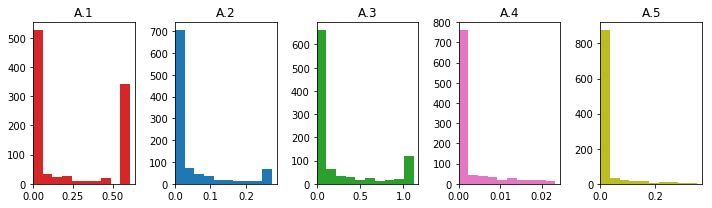

This is timestep 1


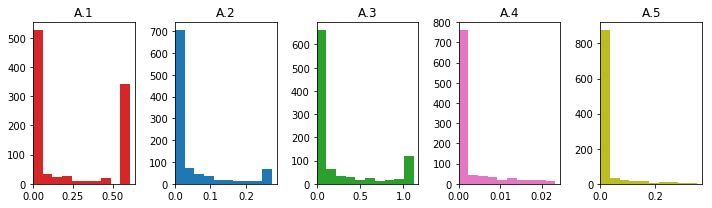

This is timestep 2


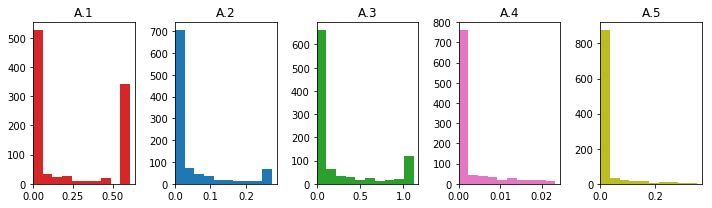

In [10]:
# # Plot Expected Number of Deaths (Histogram)
# x = [0,1,2]
# locations = ["A.1", "A.2", "A.3", "A.4", "A.5"]
# colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:pink', 'tab:olive']

# print("Plot Expected Number of Deaths (Histogram)")
# for step in x:
#     print("This is timestep " + str(step))
    
#     fig, axes = plt.subplots(1, 5, figsize=(10, 3))
    
#     for i, (ax, place) in enumerate(zip(axes.flatten(), locations)):
#         ax.hist(results[str(place) + "_Expected Number of Deaths " + str(step)], color=colors[i])
#         ax.set_xlim(left = 0)
#         ax.set_title(place)
        
#     plt.tight_layout()
#     plt.show()

Plot Dike Investment Costs (Histogram)
This is timestep 0


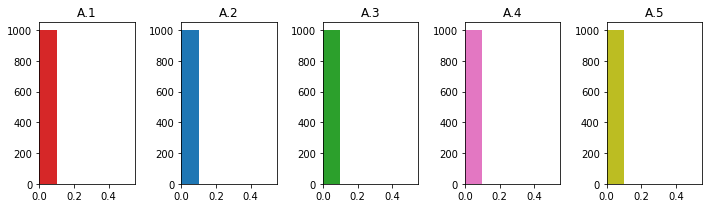

This is timestep 1


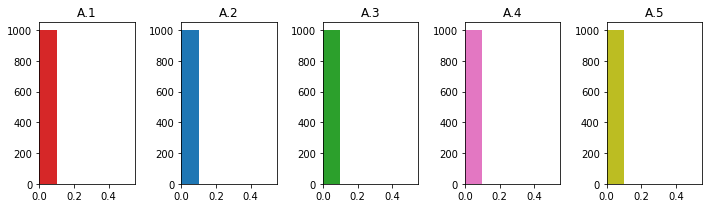

This is timestep 2


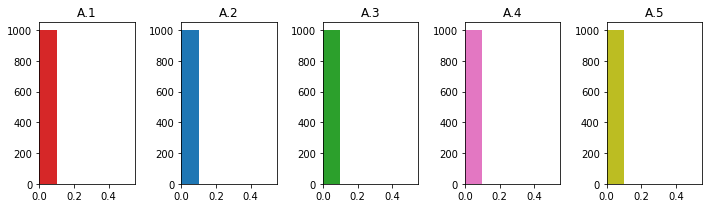

In [11]:
# # Plot Dike Investment Costs (Histogram)
# x = [0,1,2]
# locations = ["A.1", "A.2", "A.3", "A.4", "A.5"]
# colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:pink', 'tab:olive']

# print("Plot Dike Investment Costs (Histogram)")
# for step in x:
#     print("This is timestep " + str(step))
    
#     fig, axes = plt.subplots(1, 5, figsize=(10, 3))
    
#     for i, (ax, place) in enumerate(zip(axes.flatten(), locations)):
#         ax.hist(results[str(place) + "_Dike Investment Costs " + str(step)], color=colors[i])
#         ax.set_xlim(left = 0)
#         ax.set_title(place)
        
#     plt.tight_layout()
#     plt.show()

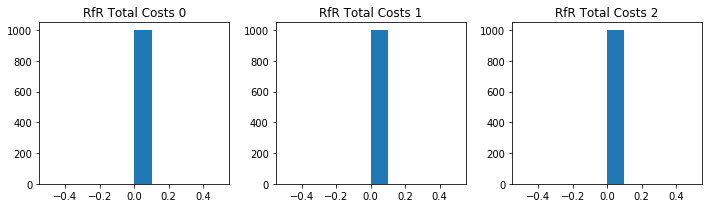

In [12]:
# fig, axes = plt.subplots(1, 3, figsize=(10, 3))

# for i, (ax, step) in enumerate(zip(axes, x)):
#     ax.hist(results["RfR Total Costs " + str(step)])
#     ax.set_title("RfR Total Costs " + str(step))
    
# plt.tight_layout()
# plt.show()

## Mean of the outcomes per location and timestep

In [55]:
# Get the mean for all the results across the scenarios to have a quick look at significant locations
mean_outcomes_df = results.iloc[:, 52:].apply(np.mean, axis = 0)

In [56]:
# https://stackoverflow.com/a/56253636
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))

In [57]:
def mean_outcomes(results):
    locations = ["A.1", "A.2", "A.3", "A.4", "A.5"]
    outcomes = ["Expected Annual Damage", "Expected Number of Deaths", "Dike Investment Costs", "RfR Total Costs"]
    x = [0, 1, 2]

    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8,8), sharex=True)
    axes = [axes[0,0],axes[0,1],axes[1,0],axes[1,1]]

    for ax, criteria in zip(axes, outcomes):
        for step in x:
            for place in locations:
                if criteria == "RfR Total Costs":
                    ax.plot(step, mean_outcomes_df[[str(criteria) + " " + str(step)]].values[0], 'ro', c ='y')
                else:
                    if place == "A.1":
                        ax.plot(step, mean_outcomes_df[[str(place) + "_" + str(criteria) + " " + str(step)]].values[0], 
                                'ro', c="b", label = "A.1")
                    elif place == "A.2":
                        ax.plot(step, mean_outcomes_df[[str(place) + "_" + str(criteria) + " " + str(step)]].values[0], 
                                'ro', c="r", label = "A.2")
                    elif place == "A.3":
                        ax.plot(step, mean_outcomes_df[[str(place) + "_" + str(criteria) + " " + str(step)]].values[0], 
                                'ro', c="g", label = "A.3")
                    elif place == "A.4":
                        ax.plot(step, mean_outcomes_df[[str(place) + "_" + str(criteria) + " " + str(step)]].values[0], 
                                'ro', c="m", label = "A.4")
                    elif place == "A.5":
                        ax.plot(step, mean_outcomes_df[[str(place) + "_" + str(criteria) + " " + str(step)]].values[0], 
                                'ro', c="c", label = "A.5")

        ax.set_xlabel("Time Steps")
        ax.set_ylabel(criteria)
        ax.set_title(str(criteria) + " over the locations", y = 1.1)
        legend_without_duplicate_labels(ax)


    plt.tight_layout()
    plt.show()

No handles with labels found to put in legend.


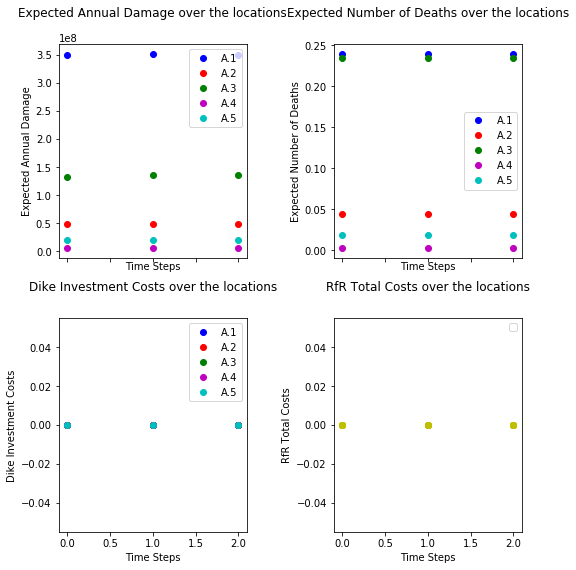

In [58]:
mean_outcomes(results)

In [ ]:
# CODE I MIGHT NEED AGAIN

# l = []

# for i in sum_results.items():
#     if("Expected Annual Damage" in i[0]):
#         l.append(i)
        
# df_exp_dmg = pd.DataFrame(l).T
# df_exp_dmg = df_exp_dmg.rename(columns=df_exp_dmg.iloc[0])
# df_exp_dmg = df_exp_dmg.reindex(df_exp_dmg.index.drop(0))

# df_exp_dmg.apply(pd.to_numeric).plot(x = df_exp_dmg.columns, y = df_exp_dmg, kind = "scatter")
# df_exp_dmg

# locations = ["A.1", "A.2", "A.3", "A.4", "A.5"]
# df_exp_dmg["subset"] = np.select([df_exp_dmg.columns.str.contains("A.1"), df_exp_dmg.columns.str.contains("A.2"),
#               df_exp_dmg.columns.str.contains("A.3"), df_exp_dmg.columns.str.contains("A.4"),
#               df_exp_dmg.columns.str.contains("A.5")], locations)

# # for color, label in zip('bgrm', [0, 1, 2, -1]):
# #     print(color)
# #     print(df_exp_dmg[df_exp_dmg.subset == label])

# exp_ann_dmg_col = []

# for i in results.columns:
#     if "Expected Annual Damage" in i:
#         exp_ann_dmg_col.append(i)
        
# exp_ann_dmg_df = results[exp_ann_dmg_col]

In [ ]:
# # Highest expected annual damage at timestep 0 across locations

# fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8,8),
#                         sharex=True)
# axes = [axes[0,0],axes[0,1],axes[1,0],axes[1,1]]

# n = 3 # Time Steps

# for i in range(n):
    
#     # FIX NEEDED: to use ax.plot otherwise it will only display the last one!
#     ax = sum_results[['A.1_Expected Annual Damage ' + str(i),'A.2_Expected Annual Damage ' + str(i), "A.3_Expected Annual Damage " + str(i),
#             "A.4_Expected Annual Damage " + str(i), "A.5_Expected Annual Damage " + str(i)]].plot(kind='bar', title ="Annual Damages per Location", legend=True)
    
#     ax.set_xlabel("Location")
#     ax.set_ylabel("Annual Damages")


# plt.tight_layout()
# plt.show()

In [ ]:
for policies in dike_model.outcomes:
    print(repr(policies))

In [ ]:
# utilities.experiments_to_scenarios(results[0]) # --> Just playing; this doesn't seem to work.

In [ ]:
for policies in dike_model.levers:
    print(repr(policies))
    
levers = copy.deepcopy(dike_model.levers)

In [ ]:
for unc in dike_model.uncertainties:
    print(repr(unc))

In [ ]:
dike_model.uncertainties = [CategoricalParameter('discount rate 0', [0, 1, 2, 3], default = 2),
                CategoricalParameter('discount rate 1', [0, 1, 2, 3], default = 2),
                CategoricalParameter('discount rate 2', [0, 1, 2, 3], default = 2),
                IntegerParameter('A.0_ID flood wave shape', 0, 132, default = 50),
                RealParameter('A.1_Bmax', 30, 350, default = 200),
                RealParameter('A.1_pfail', 0, 1, default = 0.5),
                CategoricalParameter('A.1_Brate', [0, 1, 2], default = 1),
                RealParameter('A.2_Bmax', 30, 350, default = 200),
                RealParameter('A.2_pfail', 0, 1, default = 0.5),
                CategoricalParameter('A.2_Brate', [0, 1, 2], default = 1),
                RealParameter('A.3_Bmax', 30, 350, default = 200),
                RealParameter('A.3_pfail', 0, 1, default = 0.5),
                CategoricalParameter('A.3_Brate', [0, 1, 2], default = 1),
                RealParameter('A.4_Bmax', 30, 350, default = 200),
                RealParameter('A.4_pfail', 0, 1, default = 0.5),
                CategoricalParameter('A.4_Brate', [0, 1, 2], default = 1),
                RealParameter('A.5_Bmax', 30, 350, default = 200),
                RealParameter('A.5_pfail', 0, 1, default = 0.5),
                CategoricalParameter('A.5_Brate', [0, 1, 2], default = 1)]

In [ ]:
# for unc in dike_model.uncertainties:
#     print(repr(unc))
    
# uncertainties = copy.deepcopy(dike_model.uncertainties)

# for policies in dike_model.levers:
#     print(repr(policies))
    
# levers = copy.deepcopy(dike_model.levers)

# for outcome in dike_model.outcomes:
#     print(repr(outcome))
    
# outcomes = copy.deepcopy(dike_model.outcomes)

In [ ]:
# # Save results to save computational time while in dev
# import pickle

# with open('Outcomes/1000Scenarios10Policies.pkl', 'wb') as f:
#     pickle.dump(results, f)

In [ ]:
# Read in results again
import pickle

with open('Outcomes/1000Scenarios10Policies.pkl', 'rb') as f:
    results = pickle.load(f)

results = results

In [ ]:
results

In [ ]:
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.optimize(nfe=5000, searchover="levers", epsilons=[0.1]*len(dike_model.outcomes))

In [ ]:
# Save results to save computational time while in dev
import pickle

with open('Outcomes/Optimize5000nfe0.1epsilons.pkl', 'wb') as f:
    pickle.dump(results, f)

In [ ]:
results.iloc[0, :33]

In [ ]:
results

In [ ]:
# # Save results to save computational time while in dev
# import pickle

# with open('Outcomes/Experiments200Scen4PolMCSamp.pkl', 'wb') as f:
#     pickle.dump(results, f)
    
# # Read in results again
# import pickle

# with open('data/Outcomes/Experiments200Scen4PolMCSamp.pkl', 'rb') as f:
#     results = pickle.load(f)

# experiments, outcomes = results

In [ ]:
# # Trying to change some of the levers / uncertainties to increase computational power

# def problem_formulation_actor():
   
#     # Load the model:
#     function = DikeNetwork()
#     # workbench model:
#     model = Model('dikesnet', function=function)
#     # Outcomes are all costs, thus they have to minimized:
#     direction = ScalarOutcome.MINIMIZE
    
#     model.uncertainties = uncertainties
#     model.outcomes = outcomes
    
    
#     # Range of dike heightening:
#     # CHANGE: Dike increase in steps of 5 decimeters, so the options are 0 (0 dm), 1 (5dm), 2(10dm)
#     # self.dh in dike_model_function.py changed to 0.5 -> Reduce computation power.
#     # CANCELLED
#     dike_lev = {'DikeIncrease': [0, 2]} 
    
#     # Series of five Room for the River projects:
#     rfr_lev = ['{}_RfR'.format(project_id) for project_id in range(0, 5)]

#     # Time of warning: 0, 1, 2, 3, 4 days ahead from the flood
#     EWS_lev = {'EWS_DaysToThreat': [0, 4]}  # days
    
#     levers = []
    
#     # RfR levers can be either 0 (not implemented) or 1 (implemented)
#     for lev_name in rfr_lev:
#         for n in function.planning_steps:
#             lev_name_ = '{} {}'.format(lev_name, n)
#             levers.append(IntegerParameter(lev_name_, 0, 1))

#     # Early Warning System lever
#     for lev_name in EWS_lev.keys():
#         levers.append(IntegerParameter(lev_name, EWS_lev[lev_name][0],
#                                        EWS_lev[lev_name][1]))
        
#     for dike in function.dikelist:
#         # location-related levers in the form: locationName_leversName
#         for lev_name in dike_lev.keys():
#             for n in function.planning_steps:
#                 name = "{}_{} {}".format(dike, lev_name, n)
#                 levers.append(IntegerParameter(name, dike_lev[lev_name][0],
#                                            dike_lev[lev_name][1]))
        

#     model.levers = levers
#     return model


# model = problem_formulation_actor()

# for policies in model.levers:
#     print(repr(policies))